#### Import necessary packages:

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, f1_score
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
from sklearn.metrics import precision_score, recall_score, roc_auc_score, f1_score
from PIL import Image
from colorama import Fore

#### Data pre processing:

In [2]:
# Define dataset paths
train_path = '../Dataset/Train'
test_path = '../Dataset/Test'
val_path = '../Dataset/Validation'

# Define data transformations
data_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
])

# Load datasets using ImageFolder
train_dataset = ImageFolder(root=train_path, transform=data_transform)
test_dataset = ImageFolder(root=test_path, transform=data_transform)
val_dataset = ImageFolder(root=val_path, transform=data_transform)

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)

#### Defining NN architecture:

In [3]:
# Model architecture
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 64 * 3, 128)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

Defining the complete model architecture:

In [4]:
# Instantiate the model, loss function, and optimizer
model = SimpleNN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Move the model to a device (e.g., GPU) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Print the model summary
summary(model, input_size=(3, 64, 64))  # Adjust input_size based on your image dimensions


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                [-1, 12288]               0
            Linear-2                  [-1, 128]       1,572,992
              ReLU-3                  [-1, 128]               0
           Dropout-4                  [-1, 128]               0
            Linear-5                    [-1, 1]             129
           Sigmoid-6                    [-1, 1]               0
Total params: 1,573,121
Trainable params: 1,573,121
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.05
Forward/backward pass size (MB): 0.10
Params size (MB): 6.00
Estimated Total Size (MB): 6.14
----------------------------------------------------------------


#### Function to generate F1 score:

In [5]:
#Function for generating f1 score
def net_f1score(classifier, test_loader):
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            outputs = classifier(images)
            predicted = (outputs > 0.5).float()

            true_labels.extend(labels.float().view(-1, 1).cpu().numpy())
            predicted_labels.extend(predicted.cpu().numpy())

    true_labels = np.array(true_labels).flatten()
    predicted_labels = np.array(predicted_labels).flatten()

    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    roc_auc = roc_auc_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    return precision, recall, roc_auc, f1

### Training the Model here:

In [6]:
# Training the model
num_epochs = 10

# Initialize empty lists to store results
epoch_list=[]

train_loss_list = []
train_accuracies_list = []
train_precisions_list = []
train_recalls_list = []
train_roc_aucs_list = []
train_f1_scores_list = []

validation_loss_list = []
validation_accuracies_list = []
validation_precisions_list = []
validation_recalls_list = []
validation_roc_aucs_list = []
validation_f1_scores_list = []

for epoch in range(num_epochs):
    print(f"Starting epoch: ",epoch+1)

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    model.train()

    for entry, data in enumerate(train_loader, 0):
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels.float().view(-1, 1))   
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Accumulate loss
        running_loss += loss.item()

        # Calculate accuracy
        predicted = (outputs >= 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels.float().view(-1, 1)).sum().item()


    # Model evaluation on training data set
    t_average_loss = running_loss / len(train_loader)
    t_accuracy = correct_train / total_train
    t_precision, t_recall, t_roc_auc, t_f1 = net_f1score(model, train_loader)


    # Model evaluation on validation set
    model.eval()
    correct_val = 0
    total_val = 0
    running_validation_loss = 0.0

    # Perform inference or evaluation without tracking gradients
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            validation_loss = criterion(outputs, labels.float().view(-1, 1))

            # Accumulate validation loss
            running_validation_loss += validation_loss.item()

            # Calculate validation accuracy
            predicted_val = (outputs >= 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted_val == labels.float().view(-1, 1)).sum().item()

    # Calculate average validation loss and accuracy
    v_average_loss = running_validation_loss / len(val_loader)
    v_accuracy = correct_val / total_val
    v_precision, v_recall, v_roc_auc, v_f1 = net_f1score(model, val_loader)

    epoch_count=int(int(epoch)+1)

    train_loss=round(t_average_loss * 100,2)
    train_acc=round(t_accuracy * 100, 2)
    train_precision=round(t_precision, 2)
    train_recall=round(t_recall, 2)
    train_roc_auc=round(t_roc_auc, 2)
    train_f1=round(t_f1, 2)

    val_loss=round(v_average_loss * 100,2)
    val_acc=round(v_accuracy * 100, 2)
    val_precision=round(v_precision, 2)
    val_recall=round(v_recall, 2)
    val_roc_auc=round(v_roc_auc, 2)
    val_f1=round(v_f1, 2)


    epoch_list.append(epoch_count)
    
    train_loss_list.append(train_loss)
    train_accuracies_list.append(train_acc)
    train_precisions_list.append(train_precision)
    train_recalls_list.append(train_recall)
    train_roc_aucs_list.append(train_roc_auc)
    train_f1_scores_list.append(train_f1)

    validation_loss_list.append(val_loss)
    validation_accuracies_list.append(val_acc)
    validation_precisions_list.append(val_precision)
    validation_recalls_list.append(val_recall)
    validation_roc_aucs_list.append(val_roc_auc)
    validation_f1_scores_list.append(val_f1)    

    print(f'Epoch {epoch_count}')

    print(f'Training Loss: {train_loss}%')   
    print(f'Training Accuracy: {train_acc}%')    
    print(f'Training Precision: {train_precision}')
    print(f'Training Recall: {train_recall}')
    print(f'Training ROC-AUC: {train_roc_auc}')
    print(f'Training F1 Score: {train_f1}')

    print("----------------------")

    print(f'Validation Loss: {val_loss}%')   
    print(f'Validation Accuracy: {val_acc}%')    
    print(f'Validation Precision: {val_precision}')
    print(f'Validation Recall: {val_recall}')
    print(f'Validation ROC-AUC: {val_roc_auc}')
    print(f'Validation F1 Score: {val_f1}')
        
    print("=========================================================")

print('Finished Training')

# Save the entire model (architecture and weights)
torch.save(model, 'model_ann.pth')


Starting epoch:  1
Epoch 1
Training Loss: 61.0%
Training Accuracy: 64.87%
Training Precision: 0.62
Training Recall: 0.92
Training ROC-AUC: 0.67
Training F1 Score: 0.74
----------------------
Validation Loss: 61.63%
Validation Accuracy: 65.26%
Validation Precision: 0.6
Validation Recall: 0.9
Validation ROC-AUC: 0.65
Validation F1 Score: 0.72
Starting epoch:  2
Epoch 2
Training Loss: 57.6%
Training Accuracy: 68.87%
Training Precision: 0.67
Training Recall: 0.82
Training ROC-AUC: 0.7
Training F1 Score: 0.73
----------------------
Validation Loss: 56.11%
Validation Accuracy: 71.69%
Validation Precision: 0.7
Validation Recall: 0.77
Validation ROC-AUC: 0.72
Validation F1 Score: 0.73
Starting epoch:  3
Epoch 3
Training Loss: 56.37%
Training Accuracy: 70.01%
Training Precision: 0.65
Training Recall: 0.84
Training ROC-AUC: 0.7
Training F1 Score: 0.74
----------------------
Validation Loss: 56.46%
Validation Accuracy: 71.03%
Validation Precision: 0.68
Validation Recall: 0.79
Validation ROC-AUC: 

#### Function to generate graphs:

In [7]:
# Define a function to create a plot
def create_plot(x, y_train, y_val, ylabel, filename):
    plt.figure(figsize=(8, 6))
    plt.plot(x, y_train, label='Training', marker='o')
    plt.plot(x, y_val, label='Validation', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.title(f'{ylabel} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.savefig(filename)
    plt.close()

#### Calling create_plot function:

In [8]:
# Create plots for each metric
print(epoch_list)
print(train_loss_list)
print(validation_loss_list)
create_plot(epoch_list, train_loss_list, validation_loss_list, 'Loss', 'g_loss_plot.png')
create_plot(epoch_list, train_accuracies_list, validation_accuracies_list, 'Accuracy', 'g_accuracy_plot.png')
create_plot(epoch_list, train_roc_aucs_list, validation_roc_aucs_list, 'ROC AUC', 'g_roc_auc_plot.png')
create_plot(epoch_list, train_f1_scores_list, validation_f1_scores_list, 'F1 Score', 'g_f1_score_plot.png')

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
[61.0, 57.6, 56.37, 55.34, 55.07, 54.87, 54.53, 54.09, 54.19, 53.97]
[61.63, 56.11, 56.46, 55.9, 57.04, 53.58, 54.04, 56.38, 55.0, 53.49]


#### Generates Precision & Recall graphs:

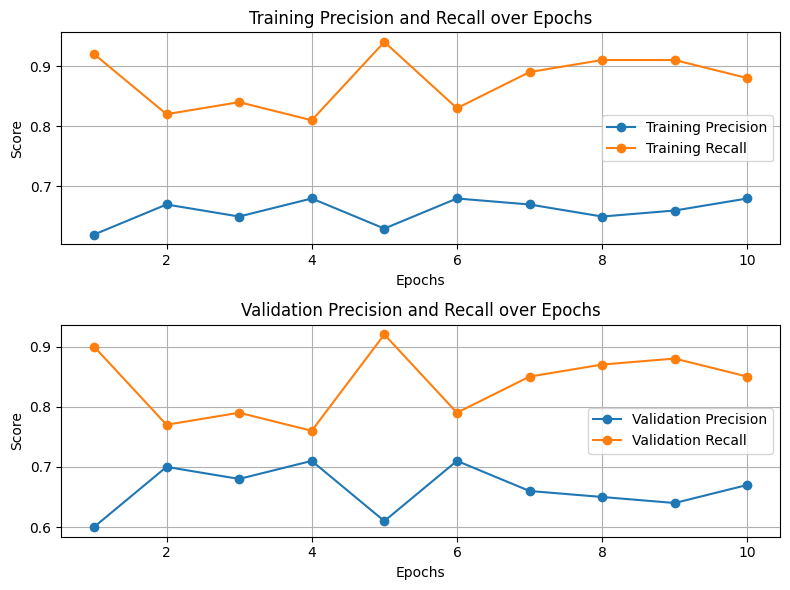

In [9]:
import matplotlib.pyplot as plt

# Ensure all lists have the same length
min_length = min(len(epoch_list), len(train_precisions_list), len(train_recalls_list),
                 len(validation_precisions_list), len(validation_recalls_list))

epoch_list = epoch_list[:min_length]
train_precisions_list = train_precisions_list[:min_length]
train_recalls_list = train_recalls_list[:min_length]
validation_precisions_list = validation_precisions_list[:min_length]
validation_recalls_list = validation_recalls_list[:min_length]

# Create two separate subplots for precision and recall
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Plot training precision and recall in the first subplot
ax1.plot(epoch_list, train_precisions_list, label='Training Precision', marker='o')
ax1.plot(epoch_list, train_recalls_list, label='Training Recall', marker='o')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Score')
ax1.set_title('Training Precision and Recall over Epochs')
ax1.legend()
ax1.grid(True)

# Plot validation precision and recall in the second subplot
ax2.plot(epoch_list, validation_precisions_list, label='Validation Precision', marker='o')
ax2.plot(epoch_list, validation_recalls_list, label='Validation Recall', marker='o')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Score')
ax2.set_title('Validation Precision and Recall over Epochs')
ax2.legend()
ax2.grid(True)

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('g_precision_recall_plot.png')
plt.show()


#### Generates all graphs in one frame:

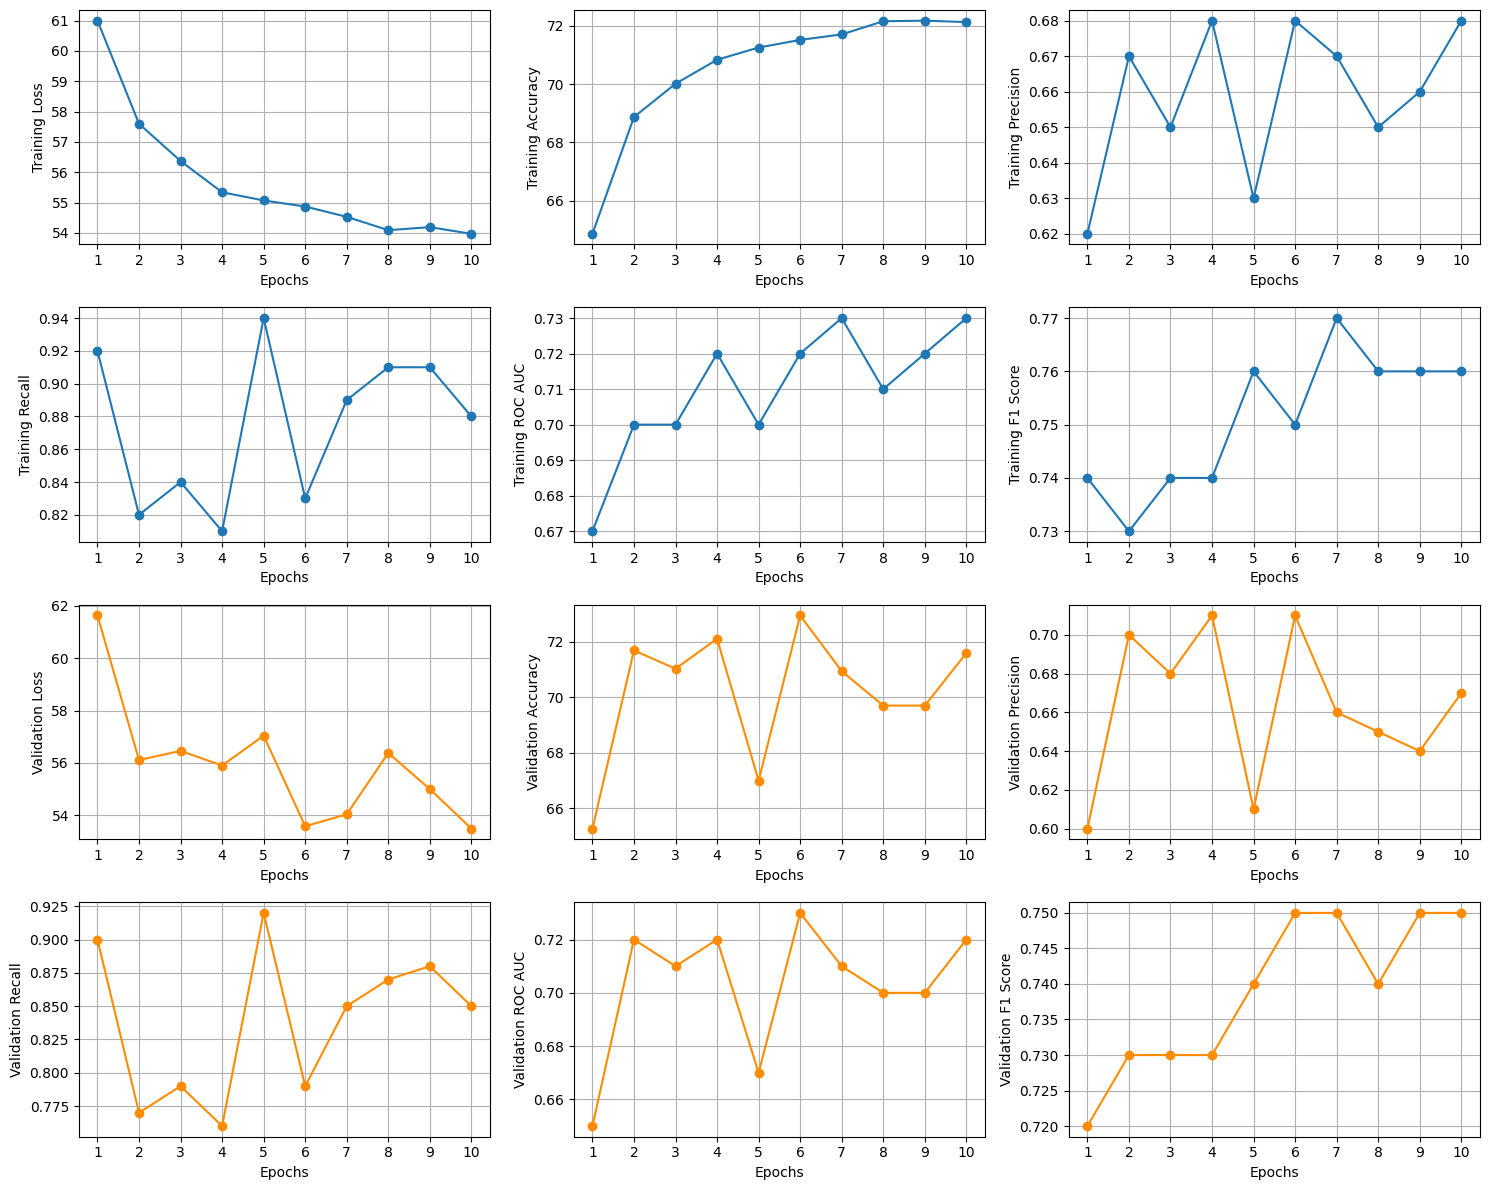

In [10]:
# Ensures all lists have the same length
min_length = min(
    len(epoch_list),
    len(train_loss_list), len(train_accuracies_list), len(train_precisions_list),
    len(train_recalls_list), len(train_roc_aucs_list), len(train_f1_scores_list),
    len(validation_loss_list), len(validation_accuracies_list), len(validation_precisions_list),
    len(validation_recalls_list), len(validation_roc_aucs_list), len(validation_f1_scores_list)
)

epoch_list = epoch_list[:min_length]

train_loss_list = train_loss_list[:min_length]
train_accuracies_list = train_accuracies_list[:min_length]
train_precisions_list = train_precisions_list[:min_length]
train_recalls_list = train_recalls_list[:min_length]
train_roc_aucs_list = train_roc_aucs_list[:min_length]
train_f1_scores_list = train_f1_scores_list[:min_length]

validation_loss_list = validation_loss_list[:min_length]
validation_accuracies_list = validation_accuracies_list[:min_length]
validation_precisions_list = validation_precisions_list[:min_length]
validation_recalls_list = validation_recalls_list[:min_length]
validation_roc_aucs_list = validation_roc_aucs_list[:min_length]
validation_f1_scores_list = validation_f1_scores_list[:min_length]

# Creates subplots for all 12 metrics
fig, axs = plt.subplots(4, 3, figsize=(15, 12))
axs = axs.flatten()

# Metric labels
metric_labels = [
    'Training Loss', 'Training Accuracy', 'Training Precision', 'Training Recall', 'Training ROC AUC', 'Training F1 Score',
    'Validation Loss', 'Validation Accuracy', 'Validation Precision', 'Validation Recall', 'Validation ROC AUC', 'Validation F1 Score'
]

# Set common labels and title
for ax, label in zip(axs, metric_labels):
    ax.set_xlabel('Epochs')
    ax.set_ylabel(label)
    ax.grid(True)
    # Set x-axis ticks as integers for each subplot
    ax.set_xticks(epoch_list)

# Plot training metrics with green color
axs[0].plot(epoch_list, train_loss_list, label='Training Loss', marker='o')
axs[1].plot(epoch_list, train_accuracies_list, label='Training Accuracy', marker='o')
axs[2].plot(epoch_list, train_precisions_list, label='Training Precision', marker='o')
axs[3].plot(epoch_list, train_recalls_list, label='Training Recall', marker='o')
axs[4].plot(epoch_list, train_roc_aucs_list, label='Training ROC AUC', marker='o')
axs[5].plot(epoch_list, train_f1_scores_list, label='Training F1 Score', marker='o')

# Plot validation metrics with darkorange color
axs[6].plot(epoch_list, validation_loss_list, label='Validation Loss', marker='o', color='darkorange')
axs[7].plot(epoch_list, validation_accuracies_list, label='Validation Accuracy', marker='o', color='darkorange')
axs[8].plot(epoch_list, validation_precisions_list, label='Validation Precision', marker='o', color='darkorange')
axs[9].plot(epoch_list, validation_recalls_list, label='Validation Recall', marker='o', color='darkorange')
axs[10].plot(epoch_list, validation_roc_aucs_list, label='Validation ROC AUC', marker='o', color='darkorange')
axs[11].plot(epoch_list, validation_f1_scores_list, label='Validation F1 Score', marker='o', color='darkorange')

# Adjust layout
plt.tight_layout()

# Save the plot
plt.savefig('g_all_metrics_subplots.png')
plt.show()


#### Running Test dataset:

In [11]:
# Model evaluation on test set
correct = 0
total = 0
test_loss = 0.0

# Lists to store true labels and model predictions
true_labels = []
model_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        predicted = (outputs >= 0.5).float()

        # Compute test loss
        loss = criterion(outputs, labels.float().view(-1, 1))
        test_loss += loss.item()

        total += labels.size(0)
        correct += (predicted == labels.float().view(-1, 1)).sum().item()
        true_labels.extend(labels.cpu().numpy())
        model_predictions.extend(outputs.cpu().numpy())

# Calculate test accuracy and test loss
test_accuracy = (correct / total)
average_test_loss = test_loss / len(test_loader)

test_loss_rounded=round(average_test_loss * 100,2)
test_acc_rounded=round(test_accuracy * 100, 2)

# Print or use the variables as needed
print(f'Test accuracy: {test_acc_rounded:.2f}%')
print(f'Test loss: {test_loss_rounded:.2f}%')

Test accuracy: 71.24%
Test loss: 54.78%


#### Predicting :

In [13]:
def showImage(path):
    # Load the image
    img = Image.open(path)
 
    # Create a figure with subplots
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))
 
    # Display the image in the subplot
    axs.imshow(img)
 
    # Disable the axis for better visualization
    axs.axis(False)
 
    # Set the background color of the figure as black
    fig.set_facecolor(color="black")
 
    # Display the plot
    plt.show()

Prediction:  REAL


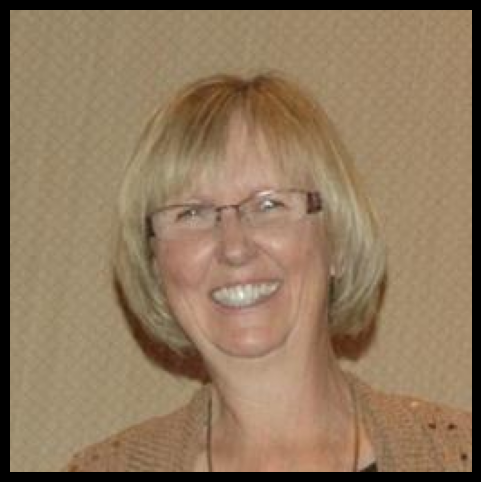

In [37]:
model.eval()  # Set the model to evaluation mode

 
# Load and preprocess the test image
path = "../Dataset/Test/Fake/fake_1003.jpg"
#path = "../Dataset/Test/Real/real_1019.jpg"
#path = "../generated-images/mid-jorney.jpg"


test_image = Image.open(path)
test_image = data_transform(test_image).unsqueeze(0)  # Add batch dimension
 
# Replicate the input tensor along the batch dimension to match the expected size (32)
batch_size = 32
test_image_batched = test_image.repeat(batch_size, 1, 1, 1)
 
# Make predictions
with torch.no_grad():
    outputs = model(test_image)
    predicted = (outputs >= 0.5).float()

 
# Process predictions as needed for each image
result = "FAKE" if predicted == 0 else "REAL"
#print(f"Prediction: {result}")
print(f"Prediction: "+Fore.BLUE,result)
showImage(path)